# EIGENFACE MODEL
***

In [1]:
import sklearn
from sklearn.datasets import fetch_lfw_people
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg as la
import seaborn as sns
import pandas as pd

### Download dataset

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=100)

### Overview of the dataset

The dataset $X$ is composed by $M$ images of size $(m \times n)$

Dimension of Dataset 
	X:	(1140, 2914)
	y:	(1140,)
Number of samples (M):  1140
Dimension images
	Height (m):	62
	Width (n):	47
Different Labels:	 ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


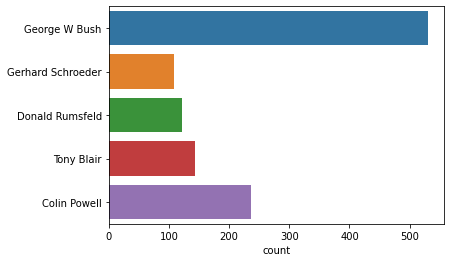

In [3]:
X = lfw_people.data.astype(int)
y = lfw_people.target
labels = lfw_people.target_names
n_samples, h, w = lfw_people.images.shape
print("Dimension of Dataset \n\tX:\t{}\n\ty:\t{}".format(np.shape(X), np.shape(y)))
print("Number of samples (M): ",str(n_samples))
print("Dimension images\n\tHeight (m):\t{}\n\tWidth (n):\t{}".format(str(h),str(w)))
print("Different Labels:\t", labels)
ax = sns.countplot(y=pd.Series([labels[i] for i in y]))

#### Image's example

2 	 George W Bush


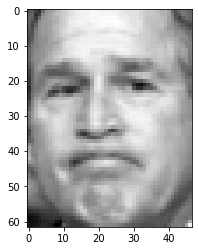

In [4]:
id = 0
example_image = X[id].reshape((h,w))
plt.imshow(example_image.reshape((h, w)), cmap=plt.cm.gray)
print(y[id],"\t",labels[y[id]])

This is the matrix representation of the dataset

In [5]:
X = np.reshape(X, newshape=(np.shape(X)[0], h, w))
print("Dimension of Dataset: {}".format(np.shape(X)))

Dimension of Dataset: (1140, 62, 47)


Split dataset into train set (10%) and test set (90%)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Shape of Train set\n\t Input: {}\tOutput: {}".format(np.shape(X_train), np.shape(y_train)))
print("Shape of Test set\n\t Input: {}\tOutput: {}".format(np.shape(X_test), np.shape(y_test)))

Shape of Train set
	 Input: (798, 62, 47)	Output: (798,)
Shape of Test set
	 Input: (342, 62, 47)	Output: (342,)


This is the distribution of classes in the training set

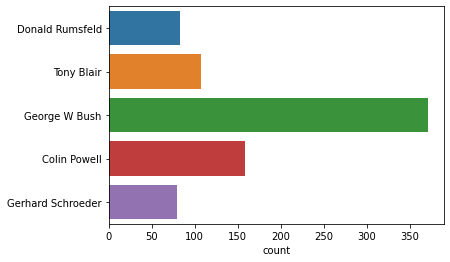

In [7]:
ax = sns.countplot(y=pd.Series([labels[i] for i in y_train]))

Undersample the set to mitigate the influence of the classes with too many samples

In [8]:
print(np.shape(X_train),"\t", np.shape(y_train))
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy='not minority')
X_train, y_train = rus.fit_resample(np.reshape(X_train, newshape=(np.shape(X_train)[0], h*w)), y_train)
X_train = np.reshape(X_train, newshape=(np.shape(X_train)[0], h, w))

(798, 62, 47) 	 (798,)


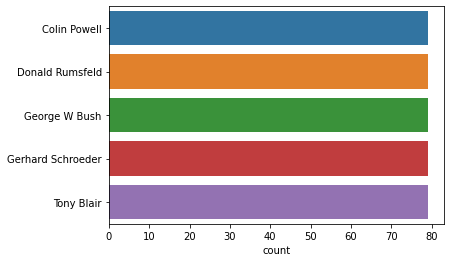

In [9]:
ax = sns.countplot(y=pd.Series([labels[i] for i in y_train]))

This is the mean face image extracted by averaging all images of the training set <br>
$\hspace{6cm} \Psi = \frac{1}{M}\cdot\sum_{i=1}^{M} \Gamma_{i}$

(62, 47)


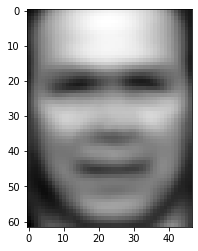

In [10]:
mean_face = X_train.mean(axis=0)
print(np.shape(mean_face))
plt.imshow(mean_face, cmap=plt.cm.gray)

This is the process of face's centering using the mean face <br>
$\phi_{i} = \Gamma_{i} - \Psi \hspace{1.5cm} (i= 1,\dots M)$

In [11]:
X_train_centered = X_train - mean_face
X_test_centered = X_test - mean_face

This is an example of the same face shown before (left) and the centered version (right)

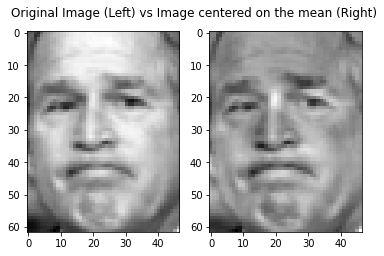

In [12]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title("Original Image (Left) vs Image centered on the mean (Right)")
plt.axis('off')
fig.add_subplot(1,2,1)
plt.imshow(example_image, cmap=plt.cm.gray)
fig.add_subplot(1,2,2)
plt.imshow(example_image - mean_face, cmap=plt.cm.gray)
plt.show()

This is the vectorized version of the centered dataset <br>
Each image has been vectorized, in this sense:<br>
$\phi_{i} \in R^{(m \times n)} \longmapsto vec(\phi_{i}) \in R^{(m \cdot n)} \hspace{2cm} 
vec(\phi_{i}) = \begin{bmatrix}(\phi_{i})_{(\ast,1)}\\(\phi_{i})_{(\ast,2)}\\ \vdots \\(\phi_{i})_{(\ast,m \cdot n)}\end{bmatrix}$<br>
This is the vectorized version of the centered dataset:<br>
$X = [ \, vec(\phi_{i}), vec(\phi_{2}), \ldots , vec(\phi_{M}) ]\,$

In [13]:
X_train_centered_vectorized = np.reshape(X_train_centered, newshape=(np.shape(X_train_centered)[0], h*w))
print("\nShape of the Vectorized version of the Train centered dataset: {}"
      .format(np.shape(X_train_centered_vectorized)))
X_test_centered_vectorized = np.reshape(X_test_centered, newshape=(np.shape(X_test_centered)[0], h*w))
print("\nShape of the Vectorized version of the Test centered dataset: {}"
      .format(np.shape(X_test_centered_vectorized)))



Shape of the Vectorized version of the Train centered dataset: (395, 2914)

Shape of the Vectorized version of the Test centered dataset: (342, 2914)


In [14]:
X_train_centered_vectorized = np.transpose(X_train_centered_vectorized)
print("\nShape of the Transposed Vectorized version of the Train centered dataset: {}"
      .format(np.shape(X_train_centered_vectorized)))

X_test_centered_vectorized = np.transpose(X_test_centered_vectorized)
print("\nShape of the Transposed Vectorized version of the Test centered dataset: {}"
      .format(np.shape(X_test_centered_vectorized)))


Shape of the Transposed Vectorized version of the Train centered dataset: (2914, 395)

Shape of the Transposed Vectorized version of the Test centered dataset: (2914, 342)


Now is required to compute the PCA of the Covariance Matrix <br>
But since the features are situated on the rows 
($pixel_{1}$, $pixel_{2}$, $pixel_{3}$, ..., $pixel_{m*n}$) 
is required to change the perspective of the matrix and 
use the transpose of the matrix $X$ <br>
Now it's possible compute PCA using the Covariance Matrix computed on ${X_{c}}^{T}$<br>
$Cov_{X_{c}} = \frac{1}{M - 1} * {(X^{T})}^{T}X^{T} = \frac{1}{M - 1} * XX^{T}$ <br>
But the matrix product is performed using two matrices of these size: <br> $(m*n$ x $M)*(M$ x $m*n)$
<br> and so the resulting matrix has shape $(m*n$ x $m*n)$ which is very bigger and requires
an high computational effort.

In [15]:
print("X {} * X^T {}\nThe matrix product returns a matrix of size ({},{})"
      .format(np.shape(X_train_centered_vectorized),
              np.shape(np.transpose(X_train_centered_vectorized)),
              np.shape(X_train_centered_vectorized)[0],
              np.shape(X_train_centered_vectorized)[0]))

X (2914, 395) * X^T (395, 2914)
The matrix product returns a matrix of size (2914,2914)


Then it's used the transpose of the original matrix. <br>
$X \in R^{(mn \times M)} \rightarrow X^{T} \in R^{(M \times mn)}$ <br>
And so, when it's computed the Covariance matrix (with this formula $\downarrow$) 
it's obtained a matrix feasible to treat<br>
$Cov_{X_{c}} = \frac{1}{M - 1} * {X}^{T}X 
\Rightarrow
(M \times mn)*(mn \times M) 
\Rightarrow
(M \times M)
$

In [16]:
print("X^T {} * X {}".
      format(np.shape(X_train_centered_vectorized.T), 
      np.shape(X_train_centered_vectorized)))

Cov_XTX = (1/(np.shape(X_train_centered_vectorized)[0] - 1)) * \
          np.dot(np.transpose(X_train_centered_vectorized), X_train_centered_vectorized)
print("Dimension of the computed Covariance Matrix: {}".format(np.shape(Cov_XTX)))

X^T (395, 2914) * X (2914, 395)
Dimension of the computed Covariance Matrix: (395, 395)


Now let's call $v_{i}$ the eigenvectors of $X^{T}X$ and write the 
basic relation which tied up eigenvectors and eigenvalues:<br>
$(X^{T}X) \cdot v_{i} = \lambda_{i} \cdot v_{i} \iff 
X\cdot (X^{T}X) \cdot v_{i} = \lambda_{i} \cdot (X \cdot v_{i}) \iff$ <br><br>
$(XX^{T}) \cdot (X \cdot v_{i}) = \lambda_{i} \cdot (X \cdot v_{i}) \implies $<br><br>
$(X \cdot v_{i}) = u_{i} $ is the $i^{th}$ eigenvector of the matrix $(XX^{T})$
***
Then it has been computed the eigenvectors of the Covariance Matrix $X^{T}X$

In [17]:
eigenvalues, eigenvectors = np.linalg.eig(Cov_XTX)
print("Shape of the set of eigenvalues: {}".format(np.shape(eigenvalues)))
print("Shape of the set of eigenvectors: {}".format(np.shape(eigenvectors)))

Shape of the set of eigenvalues: (395,)
Shape of the set of eigenvectors: (395, 395)


Using the eigenvectors $v_{i}$, 
now it can be computed the vectors $u_{i}$ also called EIGENFACES

Shape of the eigenfaces matrix: (2914, 395)


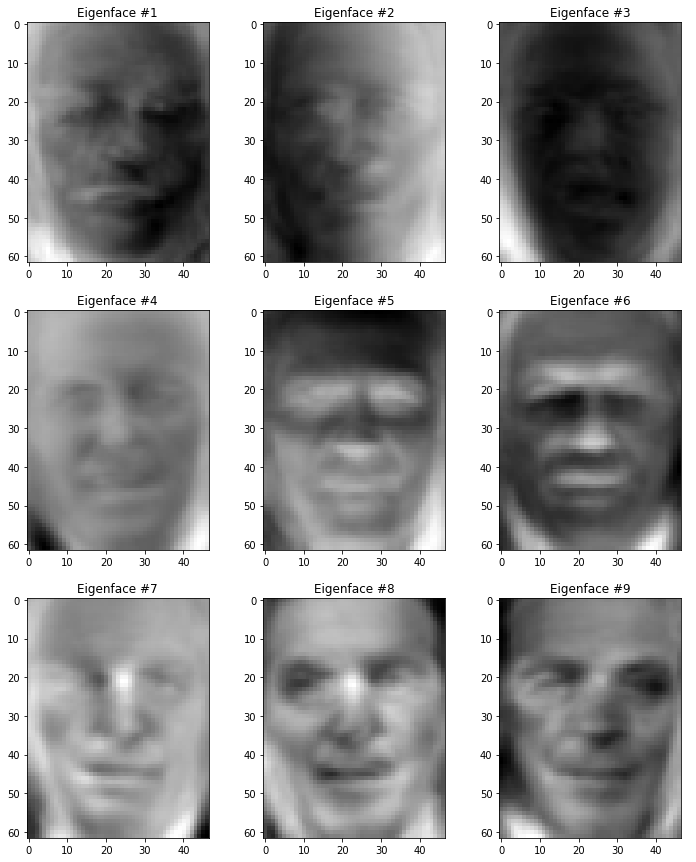

In [18]:
eigenfaces = np.dot(X_train_centered_vectorized, eigenvectors)
print("Shape of the eigenfaces matrix: {}".format(np.shape(eigenfaces)))
eigenface_example = np.reshape(eigenfaces[:,0], newshape=(h,w))
fig2 = plt.figure(figsize=(12,15),facecolor=(1, 1, 1))
plt.axis('off')
img=0
while img < 9:
    fig2.add_subplot(3,3,img+1)
    plt.title("Eigenface #{}".format(img+1))
    plt.imshow(np.reshape(eigenfaces[:,img], newshape=(h,w)), cmap=plt.cm.gray)
    img +=1
plt.show()

Now it must be chosen a number $M^{'}$ of eigenfaces, 
such that $M^{'} < M$.<br>

In [19]:
total_variation = np.sum(eigenvalues)
explained_variance = np.asarray(
    [100*(i/total_variation) for i in sorted(eigenvalues, reverse=True)])
cumulative_covariance = np.cumsum(explained_variance)

These eigenfaces has been chosen according to highest associated eigenvalues,
inspecting the cumulative explained variance (scree plot)

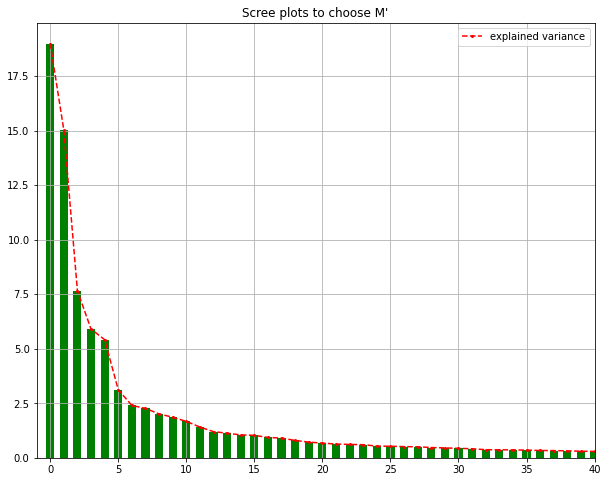

In [20]:
fig1 = plt.figure(1, figsize=(10,8))
plt.title("Scree plots to choose M\'")
plt.bar(x=np.arange(np.shape(explained_variance)[0]), 
        height=explained_variance, 
        width=0.6, color="green")
plt.plot(np.arange(np.shape(explained_variance)[0]), 
         explained_variance, 
         linestyle="--", marker="o", markersize=2,
         color="red", label="explained variance")
plt.xlim(-1,40)
#plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

This is the number of eigenfaces useful to approximate the face space

In [21]:
m_first = 5

This is the cumulative variance (embedded)

In [22]:
print("Cumulative Variance obtained taking the first {} eigenface:\t{}"
      .format(m_first, cumulative_covariance[m_first-1:m_first][0]))

Cumulative Variance obtained taking the first 5 eigenface:	52.99533461098184


These following are the retained eigenfaces

In [23]:
basis_eigenfaces = eigenfaces[:,:m_first]
print(np.shape(basis_eigenfaces))
basis_eigenfaces_t = np.transpose(basis_eigenfaces)
print(np.shape(basis_eigenfaces_t))

(2914, 5)
(5, 2914)


Now it must be computed the contribution that each retained eigenface provide to represent all images of the training set.

In [24]:
# le colonne sono gli Omega vettori per ogni immagine del training set (colonna 1 = [w_11, w_12, ..., w_1M']^T)
projections_Omega = np.dot(basis_eigenfaces_t, X_train_centered_vectorized)
print(np.shape(projections_Omega))

(5, 395)


In [25]:
# la proiezione la ottengo pesando ogni eigenface (k) con il valore di w_k
proj = np.zeros((np.shape(basis_eigenfaces)[0],1))
for i in range(m_first):
    proj += projections_Omega[i:i+1,id]*basis_eigenfaces[:,i:i+1]
proj += mean_face.reshape((h*w,1))
print(np.shape(proj))

(2914, 1)


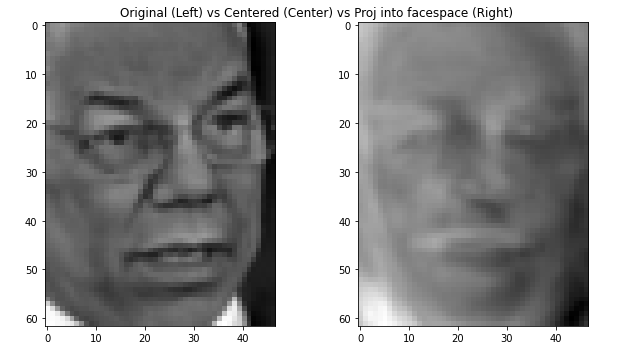

In [26]:
fig = plt.figure(figsize=(9,5), facecolor=(1, 1, 1))
plt.title("Original (Left) vs Centered (Center) vs Proj into facespace (Right)")
plt.axis('off')
fig.add_subplot(1,2,1)
plt.imshow(np.reshape(X_train_centered_vectorized[:,id], newshape=(h,w)), cmap=plt.cm.gray)
fig.add_subplot(1,2,2)
plt.imshow(proj.reshape((h,w)), cmap=plt.cm.gray)
fig.tight_layout(h_pad=2)
plt.show()


Now it will be computed the average contribution vector for each distinct class

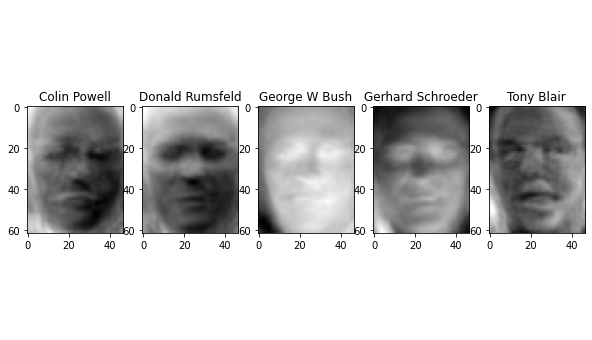

In [27]:
classes_index = {}

for count, name in enumerate(labels):
    classes_index[name] = np.where(y_train == count)

Omega_class = {}
c = 0
fig_compare = plt.figure(facecolor=(1, 1, 1), figsize=(10,6))
plt.axis('off')
for k,v in classes_index.items():
    output = np.zeros((m_first,))
    for each_index in v[0]:
        output += projections_Omega[:,each_index]
    
    output = np.reshape(output / len(v), newshape=(m_first,1))
    Omega_class[k] = output
    proj_classface = np.zeros((np.shape(basis_eigenfaces)[0],1))
    for i in range(m_first):
        proj_classface += output[i:i+1,:]*basis_eigenfaces[:,i:i+1]
    proj_classface += mean_face.reshape((h*w,1))
    c+=1
    fig_compare.add_subplot(1,len(labels),c)
    plt.imshow(proj_classface.reshape((h,w)), cmap=plt.cm.gray)
    plt.title(k)
plt.show()


### Test the Model

Each image of the test set must be projected into the subspace spanned by the $M^{'}$ basis

In [28]:
n_test = np.shape(X_test_centered_vectorized)[1]

In [29]:
X_test_centered_vectorized, y_test = X_test_centered_vectorized[:,0:n_test], y_test[0:n_test]
print(np.shape(X_test_centered_vectorized))

(2914, 342)


Now it must be computed the set of the contribution vectors $\Omega_{k}$ for all the images of the test set

In [30]:
projections_Omega_test = np.dot(basis_eigenfaces_t, X_test_centered_vectorized)
print(np.shape(projections_Omega_test), "\t\t", )

(5, 342) 		


And the it must be computed the projection of each image of the test set into the subspace 

In [31]:
projections_test_set = np.zeros((np.shape(basis_eigenfaces)[0],n_test))
for i in range(0,n_test):
    proj_ts = np.zeros((np.shape(basis_eigenfaces)[0],1))
    for j in range(m_first):
        proj_ts += projections_Omega_test[j:j+1,i]*basis_eigenfaces[:,j:j+1]
    proj_ts += mean_face.reshape((h*w,1))
    projections_test_set[:,i:i+1] = np.reshape(proj_ts, newshape=(np.shape(proj_ts)[0],1))
print(np.shape(projections_test_set))

(2914, 342)


This is an example.<br>
The original test image on the left and its projection on the right.

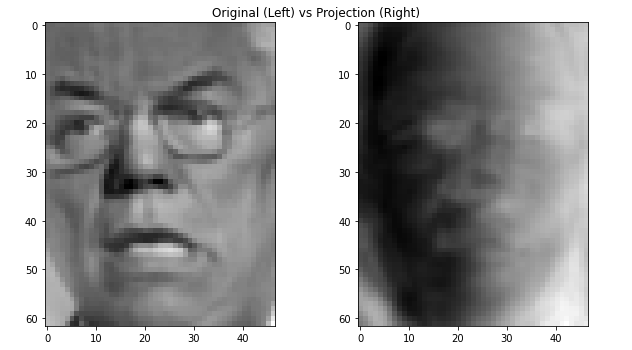

In [32]:
fig4 = plt.figure(figsize=(9,5), facecolor=(1, 1, 1))
plt.title("Original (Left) vs Projection (Right)")
plt.axis('off')
fig4.add_subplot(1,2,1)
plt.imshow(np.reshape(X_test_centered_vectorized[:,0], newshape=(h,w)), cmap=plt.cm.gray)
fig4.add_subplot(1,2,2)
plt.imshow(projections_test_set[:,0].reshape((h,w)), cmap=plt.cm.gray)
fig4.tight_layout(h_pad=2)
plt.show()

Now it must be computed the euclidean distance (2 norm squared) between each image of the test set with 
each projection of the training set.<br>
Then it must be chosen the minimum distance and if is less than a fixed threshold, then the test image is labelled
as belonging to that class, otherwise is labelled as unknown.

In [33]:
from scipy.spatial import distance

In [34]:
counters = [0, 0]
distances_test_set={}
for i in range(n_test):
    d_class = []
    d_space = 0
    for j in range(np.shape(projections_Omega)[1]):
        d_class.append(distance.euclidean(projections_Omega[:,j],projections_Omega_test[:,i]))
    #print(d_class)
    d_space = (distance.euclidean(X_test_centered_vectorized[:,i], projections_test_set[:,i]))
    id_min = np.argmin(d_class)
    #print("For test image {}: {}".format(i,d_class[id_min]))
    name_person = labels[y_train[id_min]]
    distances_test_set['Test #'+str(i)] = [d_class[id_min], d_space, name_person, labels[y_test[i]]]
    if (name_person == labels[y_test[i]]):
        counters[0] += 1
    else:
        counters[1] += 1
#for k,v in distances_test_set.items():
#    print(k,"\n - Real: {} \t Predicted: {}\n - Distance face space: {}".format(v[3], v[2], v[1]))

calcola la distanza dal face space

In [35]:
print("Right: {}\nWrong: {}".format(counters[0], counters[1]))

Right: 101
Wrong: 241


In [36]:
print("Percentage of success: {} % with {} eigenfaces"
      .format(round((counters[0]*100)/np.shape(X_test)[0],2), m_first))

Percentage of success: 29.53 % with 5 eigenfaces
